<a href="https://colab.research.google.com/github/eli-shea/csci-1470-Final-Project/blob/master/Feed_Forward_Model_for_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
from __future__ import absolute_import
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import numpy as np
import random
import math
import pandas as pd
from google.colab import drive 
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Reading in and Augmenting Data

In [ ]:
#Read in data
data_df = pd.read_csv('/drive/My Drive/Colab Notebooks/data.csv')
data_df

,Unnamed: 0,Player,Tm,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,PPRFantasyPoints,Year,Week,Def,Tgt_Allowed,ReceivingYds_Allowed,Rec_Allowed,ReceivingTD_Allowed,RushingAtt_1_Weeks_Ago,RushingYds_1_Weeks_Ago,RushingTD_1_Weeks_Ago,Rec_1_Weeks_Ago,Tgt_1_Weeks_Ago,ReceivingYds_1_Weeks_Ago,ReceivingTD_1_Weeks_Ago,PPRFantasyPoints_1_Weeks_Ago,Def_1_Weeks_Ago,Tgt_Allowed_1_Weeks_Ago,ReceivingYds_Allowed_1_Weeks_Ago,Rec_Allowed_1_Weeks_Ago,ReceivingTD_Allowed_1_Weeks_Ago,RushingAtt_2_Weeks_Ago,RushingYds_2_Weeks_Ago,RushingTD_2_Weeks_Ago,Rec_2_Weeks_Ago,Tgt_2_Weeks_Ago,ReceivingYds_2_Weeks_Ago,ReceivingTD_2_Weeks_Ago,PPRFantasyPoints_2_Weeks_Ago,Def_2_Weeks_Ago,Tgt_Allowed_2_Weeks_Ago,ReceivingYds_Allowed_2_Weeks_Ago,Rec_Allowed_2_Weeks_Ago,ReceivingTD_Allowed_2_Weeks_Ago,RushingAtt_3_Weeks_Ago,RushingYds_3_Weeks_Ago,RushingTD_3_Weeks_Ago,Rec_3_Weeks_Ago,Tgt_3_Weeks_Ago,ReceivingYds_3_Weeks_Ago,ReceivingTD_3_Weeks_Ago,PPRFantasyPoints_3_Weeks_Ago,Def_3_Weeks_Ago,Tgt_Allowed_3_Weeks_Ago,ReceivingYds_Allowed_3_Weeks_Ago,Rec_Allowed_3_Weeks_Ago,ReceivingTD_Allowed_3_Weeks_Ago
0,18054,A.J. Green,18.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,2011.0,1.0,8.0,275.0,162.0,2158.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18088,A.J. Green,18.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,2011.0,2.0,27.0,276.0,158.0,2275.0,13.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,8.0,275.0,162.0,2158.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18254,A.J. Green,18.0,0.0,0.0,0.0,4.0,5.0,29.0,0.0,6.9,2011.0,3.0,12.0,314.0,201.0,2617.0,19.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,27.0,276.0,158.0,2275.0,13.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,8.0,275.0,162.0,2158.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18281,A.J. Green,18.0,1.0,6.0,0.0,4.0,10.0,118.0,0.0,16.4,2011.0,4.0,26.0,265.0,159.0,1968.0,16.0,0.0,0.0,0.0,4.0,5.0,29.0,0.0,6.9,12.0,314.0,201.0,2617.0,19.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,27.0,276.0,158.0,2275.0,13.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,8.0,275.0,162.0,2158.0,18.0
4,18432,A.J. Green,18.0,0.0,0.0,0.0,5.0,8.0,90.0,1.0,20.0,2011.0,5.0,22.0,297.0,189.0,2663.0,18.0,1.0,6.0,0.0,4.0,10.0,118.0,0.0,16.4,26.0,265.0,159.0,1968.0,16.0,0.0,0.0,0.0,4.0,5.0,29.0,0.0,6.9,12.0,314.0,201.0,2617.0,19.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,27.0,276.0,158.0,2275.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31554,6249,Zuriel Smith,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,6.0,17.0,327.0,184.0,2211.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31555,6301,Zuriel Smith,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,7.0,15.0,353.0,200.0,2842.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,327.0,184.0,2211.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31556,6629,Zuriel Smith,4.0,0.0,0.0,0.0,2.0,2.0,38.0,0.0,5.8,2003.0,11.0,24.0,304.0,171.0,2175.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,353.0,200.0,2842.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,327.0,184.0,2211.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31557,6929,Zuriel Smith,4.0,0.0,0.0,0.0,1.0,1.0,8.0,0.0,1.8,2003.0,14.0,17.0,327.0,184.0,2211.0,14.0,0.0,0.0,0.0,2.0,2.0,38.0,0.0,5.8,24.0,304.0,171.0,2175.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,353.0,200.0,2842.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,327.0,184.0,2211.0,14.0


In [ ]:
normalization_constant = data_df['PPRFantasyPoints_3_Weeks_Ago'].max()

In [ ]:
#Normalizes Data
def normalize_data(df, cols_to_normalize):
  for col in cols_to_normalize:
    df[col] /= df[col].max()
  return df

In [ ]:
data_df

,Unnamed: 0,Player,Tm,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,PPRFantasyPoints,Year,Week,Def,Tgt_Allowed,ReceivingYds_Allowed,Rec_Allowed,ReceivingTD_Allowed,RushingAtt_1_Weeks_Ago,RushingYds_1_Weeks_Ago,RushingTD_1_Weeks_Ago,Rec_1_Weeks_Ago,Tgt_1_Weeks_Ago,ReceivingYds_1_Weeks_Ago,ReceivingTD_1_Weeks_Ago,PPRFantasyPoints_1_Weeks_Ago,Def_1_Weeks_Ago,Tgt_Allowed_1_Weeks_Ago,ReceivingYds_Allowed_1_Weeks_Ago,Rec_Allowed_1_Weeks_Ago,ReceivingTD_Allowed_1_Weeks_Ago,RushingAtt_2_Weeks_Ago,RushingYds_2_Weeks_Ago,RushingTD_2_Weeks_Ago,Rec_2_Weeks_Ago,Tgt_2_Weeks_Ago,ReceivingYds_2_Weeks_Ago,ReceivingTD_2_Weeks_Ago,PPRFantasyPoints_2_Weeks_Ago,Def_2_Weeks_Ago,Tgt_Allowed_2_Weeks_Ago,ReceivingYds_Allowed_2_Weeks_Ago,Rec_Allowed_2_Weeks_Ago,ReceivingTD_Allowed_2_Weeks_Ago,RushingAtt_3_Weeks_Ago,RushingYds_3_Weeks_Ago,RushingTD_3_Weeks_Ago,Rec_3_Weeks_Ago,Tgt_3_Weeks_Ago,ReceivingYds_3_Weeks_Ago,ReceivingTD_3_Weeks_Ago,PPRFantasyPoints_3_Weeks_Ago,Def_3_Weeks_Ago,Tgt_Allowed_3_Weeks_Ago,ReceivingYds_Allowed_3_Weeks_Ago,Rec_Allowed_3_Weeks_Ago,ReceivingTD_Allowed_3_Weeks_Ago
0,18054,A.J. Green,18.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,2011.0,1.0,8.0,275.0,162.0,2158.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18088,A.J. Green,18.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,2011.0,2.0,27.0,276.0,158.0,2275.0,13.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,8.0,275.0,162.0,2158.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18254,A.J. Green,18.0,0.0,0.0,0.0,4.0,5.0,29.0,0.0,6.9,2011.0,3.0,12.0,314.0,201.0,2617.0,19.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,27.0,276.0,158.0,2275.0,13.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,8.0,275.0,162.0,2158.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18281,A.J. Green,18.0,1.0,6.0,0.0,4.0,10.0,118.0,0.0,16.4,2011.0,4.0,26.0,265.0,159.0,1968.0,16.0,0.0,0.0,0.0,4.0,5.0,29.0,0.0,6.9,12.0,314.0,201.0,2617.0,19.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,27.0,276.0,158.0,2275.0,13.0,0.0,0.0,0.0,1.0,4.0,41.0,1.0,11.1,8.0,275.0,162.0,2158.0,18.0
4,18432,A.J. Green,18.0,0.0,0.0,0.0,5.0,8.0,90.0,1.0,20.0,2011.0,5.0,22.0,297.0,189.0,2663.0,18.0,1.0,6.0,0.0,4.0,10.0,118.0,0.0,16.4,26.0,265.0,159.0,1968.0,16.0,0.0,0.0,0.0,4.0,5.0,29.0,0.0,6.9,12.0,314.0,201.0,2617.0,19.0,0.0,0.0,0.0,10.0,14.0,124.0,1.0,28.4,27.0,276.0,158.0,2275.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31554,6249,Zuriel Smith,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,6.0,17.0,327.0,184.0,2211.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31555,6301,Zuriel Smith,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,7.0,15.0,353.0,200.0,2842.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,327.0,184.0,2211.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31556,6629,Zuriel Smith,4.0,0.0,0.0,0.0,2.0,2.0,38.0,0.0,5.8,2003.0,11.0,24.0,304.0,171.0,2175.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,353.0,200.0,2842.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,327.0,184.0,2211.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31557,6929,Zuriel Smith,4.0,0.0,0.0,0.0,1.0,1.0,8.0,0.0,1.8,2003.0,14.0,17.0,327.0,184.0,2211.0,14.0,0.0,0.0,0.0,2.0,2.0,38.0,0.0,5.8,24.0,304.0,171.0,2175.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,353.0,200.0,2842.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,327.0,184.0,2211.0,14.0


In [ ]:
#Normalizing our data
cols_to_normalize = ['RushingAtt', 'RushingYds', 'RushingTD','Rec', 'Tgt', 'ReceivingYds', 'ReceivingTD', 
                     'Tgt_Allowed', 'ReceivingYds_Allowed', 'Rec_Allowed', 'ReceivingTD_Allowed', 
                     'RushingAtt_1_Weeks_Ago',
       'RushingYds_1_Weeks_Ago', 'RushingTD_1_Weeks_Ago', 'Rec_1_Weeks_Ago',
       'Tgt_1_Weeks_Ago', 'ReceivingYds_1_Weeks_Ago',
       'ReceivingTD_1_Weeks_Ago', 'PPRFantasyPoints_1_Weeks_Ago', 'Tgt_Allowed_1_Weeks_Ago',
       'ReceivingYds_Allowed_1_Weeks_Ago', 'Rec_Allowed_1_Weeks_Ago',
       'ReceivingTD_Allowed_1_Weeks_Ago', 'RushingAtt_2_Weeks_Ago',
       'RushingYds_2_Weeks_Ago', 'RushingTD_2_Weeks_Ago', 'Rec_2_Weeks_Ago',
       'Tgt_2_Weeks_Ago', 'ReceivingYds_2_Weeks_Ago',
       'ReceivingTD_2_Weeks_Ago', 'PPRFantasyPoints_2_Weeks_Ago', 'Tgt_Allowed_2_Weeks_Ago',
       'ReceivingYds_Allowed_2_Weeks_Ago', 'Rec_Allowed_2_Weeks_Ago',
       'ReceivingTD_Allowed_2_Weeks_Ago', 'RushingAtt_3_Weeks_Ago',
       'RushingYds_3_Weeks_Ago', 'RushingTD_3_Weeks_Ago', 'Rec_3_Weeks_Ago',
       'Tgt_3_Weeks_Ago', 'ReceivingYds_3_Weeks_Ago',
       'ReceivingTD_3_Weeks_Ago', 'PPRFantasyPoints_3_Weeks_Ago','Tgt_Allowed_3_Weeks_Ago',
       'ReceivingYds_Allowed_3_Weeks_Ago', 'Rec_Allowed_3_Weeks_Ago',
       'ReceivingTD_Allowed_3_Weeks_Ago']
normalized_data = normalize_data(data_df, cols_to_normalize)

In [ ]:
normalized_data

,Unnamed: 0,Player,Tm,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,PPRFantasyPoints,Year,Week,Def,Tgt_Allowed,ReceivingYds_Allowed,Rec_Allowed,ReceivingTD_Allowed,RushingAtt_1_Weeks_Ago,RushingYds_1_Weeks_Ago,RushingTD_1_Weeks_Ago,Rec_1_Weeks_Ago,Tgt_1_Weeks_Ago,ReceivingYds_1_Weeks_Ago,ReceivingTD_1_Weeks_Ago,PPRFantasyPoints_1_Weeks_Ago,Def_1_Weeks_Ago,Tgt_Allowed_1_Weeks_Ago,ReceivingYds_Allowed_1_Weeks_Ago,Rec_Allowed_1_Weeks_Ago,ReceivingTD_Allowed_1_Weeks_Ago,RushingAtt_2_Weeks_Ago,RushingYds_2_Weeks_Ago,RushingTD_2_Weeks_Ago,Rec_2_Weeks_Ago,Tgt_2_Weeks_Ago,ReceivingYds_2_Weeks_Ago,ReceivingTD_2_Weeks_Ago,PPRFantasyPoints_2_Weeks_Ago,Def_2_Weeks_Ago,Tgt_Allowed_2_Weeks_Ago,ReceivingYds_Allowed_2_Weeks_Ago,Rec_Allowed_2_Weeks_Ago,ReceivingTD_Allowed_2_Weeks_Ago,RushingAtt_3_Weeks_Ago,RushingYds_3_Weeks_Ago,RushingTD_3_Weeks_Ago,Rec_3_Weeks_Ago,Tgt_3_Weeks_Ago,ReceivingYds_3_Weeks_Ago,ReceivingTD_3_Weeks_Ago,PPRFantasyPoints_3_Weeks_Ago,Def_3_Weeks_Ago,Tgt_Allowed_3_Weeks_Ago,ReceivingYds_Allowed_3_Weeks_Ago,Rec_Allowed_3_Weeks_Ago,ReceivingTD_Allowed_3_Weeks_Ago
0,18054,A.J. Green,18.0,0.000000,0.000000,0.0,0.047619,0.142857,0.124620,0.25,11.1,2011.0,1.0,8.0,0.654762,0.637795,0.610294,0.642857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18088,A.J. Green,18.0,0.000000,0.000000,0.0,0.476190,0.500000,0.376900,0.25,28.4,2011.0,2.0,27.0,0.657143,0.622047,0.643382,0.464286,0.000000,0.000000,0.0,0.047619,0.142857,0.124620,0.25,0.178744,8.0,0.654762,0.637795,0.610294,0.642857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18254,A.J. Green,18.0,0.000000,0.000000,0.0,0.190476,0.178571,0.088146,0.00,6.9,2011.0,3.0,12.0,0.747619,0.791339,0.740102,0.678571,0.000000,0.000000,0.0,0.476190,0.500000,0.376900,0.25,0.457327,27.0,0.657143,0.622047,0.643382,0.464286,0.0,0.0,0.0,0.047619,0.142857,0.124620,0.25,0.178744,8.0,0.654762,0.637795,0.610294,0.642857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18281,A.J. Green,18.0,0.038462,0.033898,0.0,0.190476,0.357143,0.358663,0.00,16.4,2011.0,4.0,26.0,0.630952,0.625984,0.556561,0.571429,0.000000,0.000000,0.0,0.190476,0.178571,0.088146,0.00,0.111111,12.0,0.747619,0.791339,0.740102,0.678571,0.0,0.0,0.0,0.476190,0.500000,0.376900,0.25,0.457327,27.0,0.657143,0.622047,0.643382,0.464286,0.0,0.0,0.0,0.055556,0.153846,0.12462,0.25,0.178744,8.0,0.654762,0.637795,0.610294,0.642857
4,18432,A.J. Green,18.0,0.000000,0.000000,0.0,0.238095,0.285714,0.273556,0.25,20.0,2011.0,5.0,22.0,0.707143,0.744094,0.753111,0.642857,0.047619,0.057143,0.0,0.190476,0.357143,0.358663,0.00,0.264090,26.0,0.630952,0.625984,0.556561,0.571429,0.0,0.0,0.0,0.190476,0.178571,0.088146,0.00,0.111111,12.0,0.747619,0.791339,0.740102,0.678571,0.0,0.0,0.0,0.555556,0.538462,0.37690,0.25,0.457327,27.0,0.657143,0.622047,0.643382,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31554,6249,Zuriel Smith,4.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,2003.0,6.0,17.0,0.778571,0.724409,0.625283,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31555,6301,Zuriel Smith,4.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,2003.0,7.0,15.0,0.840476,0.787402,0.803733,0.571429,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,17.0,0.778571,0.724409,0.625283,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31556,6629,Zuriel Smith,4.0,0.000000,0.000000,0.0,0.095238,0.071429,0.115502,0.00,5.8,2003.0,11.0,24.0,0.723810,0.673228,0.615102,0.535714,0.000000,0.000000,0

In [ ]:
#Splits training and testing data
#Takes in our large dataframe and a list of years that will belong to testing data
#Returns training df and testing df
def train_test_split_by_year(df, testing_year_list):
  training_data = df[~df['Year'].isin(testing_year_list)]
  testing_data = df[df['Year'].isin(testing_year_list)]
  return training_data, testing_data

In [ ]:
#Split training and testing data by year
#testing_year_list = [2001, 2005, 2009, 2013, 2017]
testing_year_list = [2018]
training_data, testing_data = train_test_split_by_year(normalized_data, testing_year_list)

In [ ]:
#Drop NaNs so that we have all features for examples
training_data = training_data.dropna()
testing_data = testing_data.dropna()

In [ ]:
#Takes in dataframe and drops features we aren't training on and separates inputs and labels
def get_inputs_and_labels(df, non_feature_cols, label_col):
  labels = df[label_col]
  inputs = df.drop(columns=non_feature_cols)
  inputs = inputs.drop(columns=label_col)
  return inputs, labels

In [ ]:
training_data.columns

Index(['Unnamed: 0', 'Player', 'Tm', 'RushingAtt', 'RushingYds', 'RushingTD',
       'Rec', 'Tgt', 'ReceivingYds', 'ReceivingTD', 'PPRFantasyPoints', 'Year',
       'Week', 'Def', 'Tgt_Allowed', 'ReceivingYds_Allowed', 'Rec_Allowed',
       'ReceivingTD_Allowed', 'RushingAtt_1_Weeks_Ago',
       'RushingYds_1_Weeks_Ago', 'RushingTD_1_Weeks_Ago', 'Rec_1_Weeks_Ago',
       'Tgt_1_Weeks_Ago', 'ReceivingYds_1_Weeks_Ago',
       'ReceivingTD_1_Weeks_Ago', 'PPRFantasyPoints_1_Weeks_Ago',
       'Def_1_Weeks_Ago', 'Tgt_Allowed_1_Weeks_Ago',
       'ReceivingYds_Allowed_1_Weeks_Ago', 'Rec_Allowed_1_Weeks_Ago',
       'ReceivingTD_Allowed_1_Weeks_Ago', 'RushingAtt_2_Weeks_Ago',
       'RushingYds_2_Weeks_Ago', 'RushingTD_2_Weeks_Ago', 'Rec_2_Weeks_Ago',
       'Tgt_2_Weeks_Ago', 'ReceivingYds_2_Weeks_Ago',
       'ReceivingTD_2_Weeks_Ago', 'PPRFantasyPoints_2_Weeks_Ago',
       'Def_2_Weeks_Ago', 'Tgt_Allowed_2_Weeks_Ago',
       'ReceivingYds_Allowed_2_Weeks_Ago', 'Rec_Allowed_2_Weeks_Ago',
  

In [ ]:
#Gets our training and testing inputs and labels
non_features = ['Player', 'Tm', 'Def', 'Year' , 'Week', 'Unnamed: 0', 'RushingAtt', 'RushingYds', 'RushingTD',
       'Rec', 'Tgt', 'ReceivingYds', 'ReceivingTD', 'Def_1_Weeks_Ago', 'Def_2_Weeks_Ago', 'Def_3_Weeks_Ago']
label = ['PPRFantasyPoints']
training_inputs, training_labels = get_inputs_and_labels(training_data, non_features, label)
testing_inputs, testing_labels = get_inputs_and_labels(testing_data, non_features, label)

In [ ]:
testing_inputs.columns

Index(['Tgt_Allowed', 'ReceivingYds_Allowed', 'Rec_Allowed',
       'ReceivingTD_Allowed', 'RushingAtt_1_Weeks_Ago',
       'RushingYds_1_Weeks_Ago', 'RushingTD_1_Weeks_Ago', 'Rec_1_Weeks_Ago',
       'Tgt_1_Weeks_Ago', 'ReceivingYds_1_Weeks_Ago',
       'ReceivingTD_1_Weeks_Ago', 'PPRFantasyPoints_1_Weeks_Ago',
       'Tgt_Allowed_1_Weeks_Ago', 'ReceivingYds_Allowed_1_Weeks_Ago',
       'Rec_Allowed_1_Weeks_Ago', 'ReceivingTD_Allowed_1_Weeks_Ago',
       'RushingAtt_2_Weeks_Ago', 'RushingYds_2_Weeks_Ago',
       'RushingTD_2_Weeks_Ago', 'Rec_2_Weeks_Ago', 'Tgt_2_Weeks_Ago',
       'ReceivingYds_2_Weeks_Ago', 'ReceivingTD_2_Weeks_Ago',
       'PPRFantasyPoints_2_Weeks_Ago', 'Tgt_Allowed_2_Weeks_Ago',
       'ReceivingYds_Allowed_2_Weeks_Ago', 'Rec_Allowed_2_Weeks_Ago',
       'ReceivingTD_Allowed_2_Weeks_Ago', 'RushingAtt_3_Weeks_Ago',
       'RushingYds_3_Weeks_Ago', 'RushingTD_3_Weeks_Ago', 'Rec_3_Weeks_Ago',
       'Tgt_3_Weeks_Ago', 'ReceivingYds_3_Weeks_Ago',
       'ReceivingTD_3

Model

In [ ]:
#Defining our model
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()

    self.learning_rate = 1e-3
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.num_epochs = 10
    self.batch_size = 256
    self.loss_list = []

    self.model = tf.keras.Sequential()
    self.model.add(tf.keras.layers.InputLayer(40))
    self.model.add(tf.keras.layers.Dense(24, 'relu'))
    self.model.add(tf.keras.layers.Dense(6, 'relu'))
    self.model.add(tf.keras.layers.Dense(1))
  
  def call(self, inputs):
    output = self.model(inputs)
    return output
  
  def loss(self, predictions, labels):
    loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(labels, predictions))
    return loss

In [ ]:
def train(model, train_inputs, train_labels):
  shuffled_index = tf.random.shuffle(range(len(train_labels)))
  shuffled_inputs = tf.gather(train_inputs, shuffled_index)
  shuffled_labels = tf.gather(train_labels, shuffled_index)

  for i in range(len(train_labels)//model.batch_size):
    start_index = i * model.batch_size
    end_index = min((i+1) * model.batch_size, len(train_labels))

    model_inputs = shuffled_inputs[start_index:end_index]
    model_labels = shuffled_labels[start_index:end_index]

    with tf.GradientTape() as tape:
        predictions = model.call(model_inputs)
        loss = model.loss(predictions, model_labels)
        model.loss_list.append(float(loss))
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return model.loss_list

def test(model, test_inputs, test_labels):
  test_inputs = tf.convert_to_tensor(test_inputs)
  predictions = model.call(test_inputs)
  return model.loss(predictions, test_labels)

In [ ]:
def get_ffill_labels(testing_inputs, normalization_constant):
  ffill_labels = testing_inputs['PPRFantasyPoints_1_Weeks_Ago'].copy()
  ffill_labels *= normalization_constant
  return ffill_labels

In [ ]:
def mean_absolute_error_eval(predictions, labels):
  return tf.reduce_mean(tf.keras.metrics.mean_absolute_error(labels, predictions))

In [ ]:
model = Model()

loss_list = []

for i in range(model.num_epochs):
  cur_loss = train(model, training_inputs, training_labels)
  loss_list.append(cur_loss)


loss = test(model, testing_inputs, testing_labels)
print("Loss: ", loss)

ffill_labels = get_ffill_labels(testing_inputs, normalization_constant)
ffill_loss = model.loss(ffill_labels, testing_labels)
print('Front Fill Loss: ', ffill_loss)

Loss:  tf.Tensor(50.408867, shape=(), dtype=float32)
Front Fill Loss:  tf.Tensor(122.70975938556413, shape=(), dtype=float64)


In [ ]:
predictions = model.call(tf.convert_to_tensor(testing_inputs))
mae_model = mean_absolute_error_eval(predictions, testing_labels)
mae_ffill = mean_absolute_error_eval(ffill_labels, testing_labels)
print('Mean Absolute Error for our Model: ', mae_model)
print('Mean Absolute Error for Front Fill: ', mae_ffill)

Mean Absolute Error for our Model:  tf.Tensor(5.4151983, shape=(), dtype=float32)
Mean Absolute Error for Front Fill:  tf.Tensor(8.446568052403036, shape=(), dtype=float64)


In [ ]:
def visualize_loss(losses): 
    """
    Uses Matplotlib to visualize the losses of our model.
    :param losses: list of loss data stored from train. Can use the model's loss_list 
    field 

    NOTE: DO NOT EDIT

    :return: doesn't return anything, a plot should pop-up 
    """
    x = [i for i in range(len(losses))]
    plt.plot(x, losses)
    plt.title('Loss per batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()  

In [ ]:
loss_list

[ListWrapper([180.39495849609375, 188.65756225585938, 150.579833984375, 185.5445556640625, 144.0343780517578, 171.7278594970703, 164.00833129882812, 175.80357360839844, 174.87741088867188, 172.86117553710938, 169.24359130859375, 154.40597534179688, 195.0906982421875, 129.03367614746094, 155.48928833007812, 176.124755859375, 193.3955535888672, 128.91201782226562, 181.9322967529297, 153.8371124267578, 163.11602783203125, 165.32272338867188, 177.54281616210938, 184.42987060546875, 158.0743408203125, 148.61224365234375, 163.92828369140625, 175.13113403320312, 148.0086669921875, 149.63906860351562, 164.89938354492188, 157.86770629882812, 158.32327270507812, 185.16583251953125, 153.88482666015625, 157.25320434570312, 165.4674530029297, 141.3717041015625, 134.14950561523438, 133.06715393066406, 191.49801635742188, 147.37265014648438, 173.640625, 174.9944305419922, 140.78067016601562, 166.75494384765625, 169.4806365966797, 129.9560546875, 177.46957397460938, 147.53158569335938, 138.79512023925

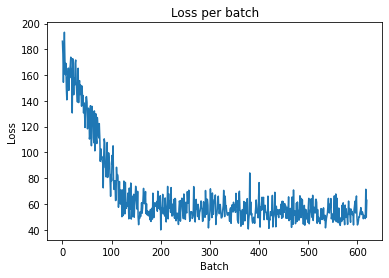

In [ ]:
visualize_loss(loss_list[i])

Text(0.5, 1.0, 'Model Projections vs. Actual Scores')

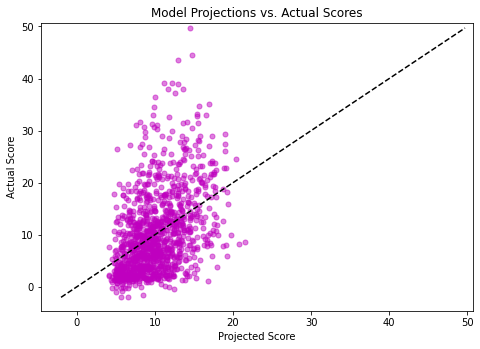

In [ ]:


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(predictions, testing_labels, s=25, c='m', alpha=.5)
limit = max(np.array(predictions).max(), np.array(testing_labels).max())
min_limit = min(np.array(predictions).min(), np.array(testing_labels).min())
ax.plot([min_limit, limit], [min_limit,limit], 'k--')
plt.xlim(right=limit + 1)
plt.ylim(top=limit + 1)
plt.xlabel('Projected Score')
plt.ylabel('Actual Score')
plt.title('Model Projections vs. Actual Scores')

Text(0.5, 1.0, 'Front Filled Projections vs. Actual Scores')

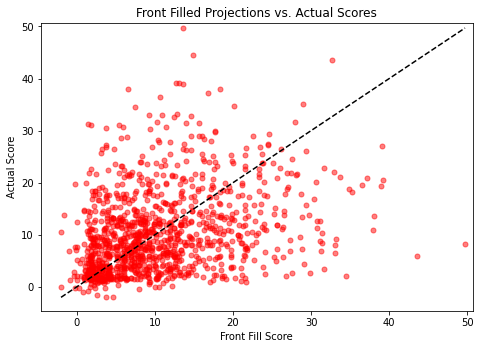

In [ ]:


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(ffill_labels, testing_labels, s=25, c='r', alpha=.5)
limit = max(np.array(ffill_labels).max(), np.array(testing_labels).max())
min_limit = min(np.array(ffill_labels).min(), np.array(testing_labels).min())
ax.plot([min_limit, limit], [min_limit,limit], 'k--')
plt.xlim(right=limit + 1)
plt.ylim(top=limit + 1)
plt.xlabel('Front Fill Score')
plt.ylabel('Actual Score')
plt.title('Front Filled Projections vs. Actual Scores')

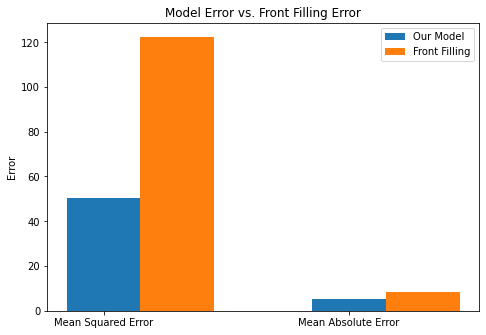

In [ ]:
#Bar graphs comparing error
error_names = ['Mean Squared Error', 'Mean Absolute Error']
errors = [[test(model, testing_inputs, testing_labels), mae_model], [model.loss(ffill_labels, testing_labels), mae_ffill]]
x = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(error_names, errors[0], .3, )
ax.bar(x + .3, errors[1], .3)
plt.ylabel('Error')
plt.title('Model Error vs. Front Filling Error')
plt.legend(['Our Model', 'Front Filling'])

Sensativity Analysis

In [ ]:

with tf.GradientTape() as g:
  SA_tensor = tf.Variable(training_inputs[900:1000])
  g.watch(SA_tensor)
  predictions = model.call(SA_tensor)
gradients = g.gradient(predictions, SA_tensor)
# print(gradients)
avg_grad_list = []
for i in range(len(gradients[0])):
  cur_avg_grad = 0
  for j in range(len(gradients)):
    cur_avg_grad += gradients[j][i]
  cur_avg_grad /= len(gradients)
  avg_grad_list.append(cur_avg_grad)

saliency_dict = {}
for i, col in enumerate(testing_inputs.columns):
  saliency_dict[abs(float(avg_grad_list[i]))] = col
saliency_dict


{0.005863030035980046: 'RushingTD_1_Weeks_Ago',
 0.027379770511761308: 'Tgt_Allowed_2_Weeks_Ago',
 0.0676340550929308: 'Tgt_Allowed_1_Weeks_Ago',
 0.18444155901670456: 'ReceivingYds_Allowed',
 0.24980849519371987: 'RushingAtt_1_Weeks_Ago',
 0.2548289392888546: 'ReceivingTD_Allowed',
 0.2625867051631212: 'ReceivingTD_Allowed_1_Weeks_Ago',
 0.2648978953063488: 'Rec_Allowed_2_Weeks_Ago',
 0.2881401696801186: 'ReceivingYds_Allowed_2_Weeks_Ago',
 0.3835485076904297: 'Tgt_Allowed',
 0.4023344647884369: 'Rec_Allowed',
 0.40938182204961776: 'ReceivingTD_Allowed_3_Weeks_Ago',
 0.4464159128069878: 'RushingYds_2_Weeks_Ago',
 0.45570937514305115: 'ReceivingYds_Allowed_1_Weeks_Ago',
 0.46707071185112: 'RushingYds_1_Weeks_Ago',
 0.4882770588994026: 'Rec_Allowed_3_Weeks_Ago',
 0.5302174216508866: 'ReceivingYds_Allowed_3_Weeks_Ago',
 0.7161383986473083: 'ReceivingTD_Allowed_2_Weeks_Ago',
 0.7867744159698487: 'Rec_Allowed_1_Weeks_Ago',
 0.8287786370515824: 'RushingAtt_3_Weeks_Ago',
 0.832486138343811: 

[(0.005863030035980046, 'RushingTD_1_Weeks_Ago'), (0.027379770511761308, 'Tgt_Allowed_2_Weeks_Ago'), (0.0676340550929308, 'Tgt_Allowed_1_Weeks_Ago'), (0.18444155901670456, 'ReceivingYds_Allowed'), (0.24980849519371987, 'RushingAtt_1_Weeks_Ago'), (0.2548289392888546, 'ReceivingTD_Allowed'), (0.2625867051631212, 'ReceivingTD_Allowed_1_Weeks_Ago'), (0.2648978953063488, 'Rec_Allowed_2_Weeks_Ago'), (0.2881401696801186, 'ReceivingYds_Allowed_2_Weeks_Ago'), (0.3835485076904297, 'Tgt_Allowed'), (0.4023344647884369, 'Rec_Allowed'), (0.40938182204961776, 'ReceivingTD_Allowed_3_Weeks_Ago'), (0.4464159128069878, 'RushingYds_2_Weeks_Ago'), (0.45570937514305115, 'ReceivingYds_Allowed_1_Weeks_Ago'), (0.46707071185112, 'RushingYds_1_Weeks_Ago'), (0.4882770588994026, 'Rec_Allowed_3_Weeks_Ago'), (0.5302174216508866, 'ReceivingYds_Allowed_3_Weeks_Ago'), (0.7161383986473083, 'ReceivingTD_Allowed_2_Weeks_Ago'), (0.7867744159698487, 'Rec_Allowed_1_Weeks_Ago'), (0.8287786370515824, 'RushingAtt_3_Weeks_Ago'),

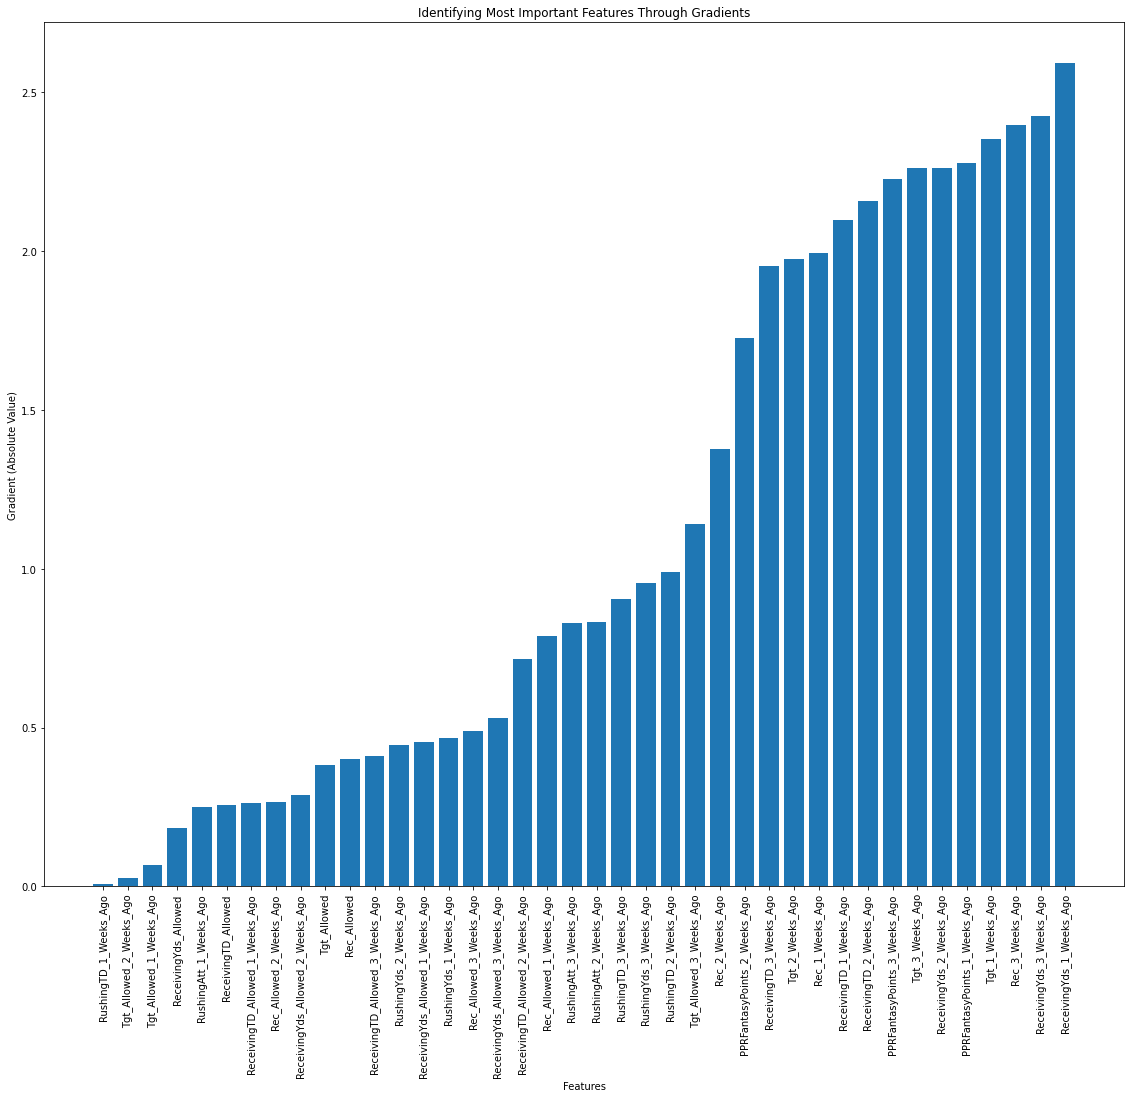

In [ ]:
fig = plt.figure(figsize=[15, 12])
ax = fig.add_axes([0, 0, 1, 1])
items = sorted(list(saliency_dict.items()))
print(items)
xvals = []
yvals = []
for i in range(len(items)):
  xvals.append(items[i][1])
  yvals.append(items[i][0])
ax.bar(xvals, yvals)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Gradient (Absolute Value)')
plt.title('Identifying Most Important Features Through Gradients')
plt.show()

Distribution of Error

              0  Score - Projection
0      3.658087            2.220712
1      2.061232            2.471030
2     -9.718920            2.870502
3    -13.341334            4.615237
4      0.205171            3.064433
...         ...                 ...
5368   1.983141                 NaN
5369  -9.036183                 NaN
5370  -0.278555                 NaN
5371  -1.279030                 NaN
5372   8.105910                 NaN

[5373 rows x 2 columns]
1159
1159


[Text(0.5, 1.0, 'Distribution of Actual Score Minus Projected Score')]

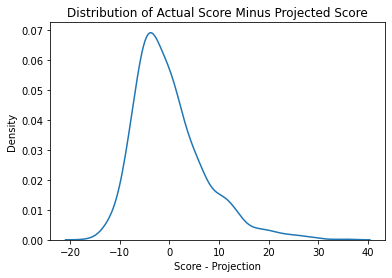

In [ ]:
import seaborn as sns
MAE['Score - Projection'] = pd.DataFrame(np.array(testing_labels) - np.array(predictions))
print(MAE)
print(len(testing_labels))
print(len(predictions))
sns.kdeplot(MAE['Score - Projection']).set(title='Distribution of Actual Score Minus Projected Score')